In [1]:
import tensorrt as trt
import pycuda.driver as cuda
try:
    import pycuda.autoprimaryctx
except ModuleNotFoundError:
    import pycuda.autoinit
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
from utils import get_image, resize_and_pad, transform, cxcywh2xyxy, mulit_colors, load_yaml

In [2]:
trt.__version__

'8.6.1'

# yolo export

```sh
yolo task=detect mode=export imgsz=640 model=weights/rtdetr-l.pt format=engine simplify=True device=0 # 可以用simplify的onnx

yolo task=detect mode=export imgsz=640 model=weights/rtdetr-l.pt format=engine simplify=True device=0 half=True
```

# funcs

In [3]:
# h w
imgsz = 640, 640

In [4]:
def to_origin_size(detections_in: np.ndarray, ratio: float, shape: np.ndarray) -> np.ndarray:
    """将将检测结果的坐标还原到原图尺寸

    Args:
        detections (np.ndarray): np.float32
                [
                    [class_index, confidences, xmin, ymin, xmax, ymax],
                    ...
                ]
        delta_w (int):      填充的宽
        delta_h (int):      填充的高
        shape (np.ndarray): 原始形状 (h, w, c)

    Returns:
        np.ndarray: same as detections
    """
    if len(detections_in) == 0:
        return detections_in

    detections = detections_in.copy()
    # 还原到原图尺寸(detections_in是归一化的,因此要乘上imgsz,再除以缩放比例)
    detections[..., 2] = detections[..., 2] * imgsz[1] / ratio  # xmin
    detections[..., 3] = detections[..., 3] * imgsz[0] / ratio  # ymin
    detections[..., 4] = detections[..., 4] * imgsz[1] / ratio  # xmax
    detections[..., 5] = detections[..., 5] * imgsz[0] / ratio  # ymax

    # 防止框超出图片边界, 前面判断为True/False,后面选择更改的列,不选择更改的列会将整行都改为0
    detections[detections[..., 2] < 0.0, 2] = 0.0
    detections[detections[..., 3] < 0.0, 3] = 0.0
    detections[detections[..., 4] > shape[1], 4] = shape[1]
    detections[detections[..., 5] > shape[0], 5] = shape[0]

    return detections

In [5]:
colors: list = mulit_colors(80)
colors[:5]

[(255, 76, 76), (255, 89, 76), (255, 103, 76), (255, 116, 76), (255, 130, 76)]

In [6]:
config: dict = load_yaml("./weights/yolov8.yaml")
config["names"]

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [7]:
def figure(detections: np.ndarray, image: np.ndarray) -> np.ndarray:
    """将框画到原图

    Args:
        detections (np.ndarray): np.float32
                [
                    [class_index, confidences, xmin, ymin, xmax, ymax],
                    ...
                ]
        image (np.ndarray): 原图

    Returns:
        np.ndarray: 绘制的图
    """
    if len(detections) == 0:
        # 返回原图
        return image

    # Print results and save Figure with detections
    for i, detection in enumerate(detections):
        classId     = int(detection[0])
        confidence  = detection[1]
        xmin        = int(detection[2])
        ymin        = int(detection[3])
        xmax        = int(detection[4])
        ymax        = int(detection[5])

        # 绘制框
        image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), colors[classId], 2)
        # 直接在原图上绘制文字背景，不透明
        # image = cv2.rectangle(image, (xmin, ymin - 20), (xmax, ymax)), self.colors[classId], cv2.FILLED)

        # 文字
        label = str(config["names"][classId]) + " " + "{:.2f}".format(confidence)
        w, h = cv2.getTextSize(label, 0, fontScale=0.5, thickness=1)[0]  # text width, height

        # 添加文字背景
        temp_image = np.zeros(image.shape).astype(np.uint8)
        temp_image = cv2.rectangle(temp_image, (xmin, ymin - 20 if ymin > 20 else ymin + h + 10), (xmax, ymin), colors[classId], cv2.FILLED)
        # 叠加原图和文字背景，文字背景是透明的
        image = cv2.addWeighted(image, 1.0, temp_image, 1.0, 1)

        # 添加文字
        image = cv2.putText(
            img       = image,
            text      = label,
            org       = (xmin, ymin - 5 if ymin > 20 else ymin + h + 5),
            fontFace  = 0,
            fontScale = 0.5,
            color     = (0, 0, 0),
            thickness = 1,
            lineType  = cv2.LINE_AA,
        )

    return image

# prepare image

(1080, 810, 3)


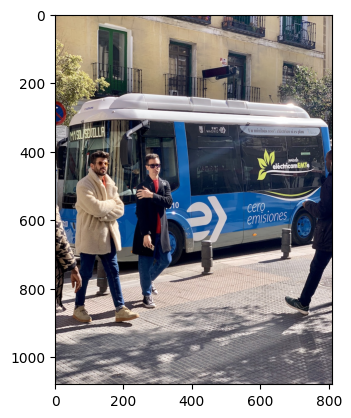

In [8]:
image_rgb = get_image("images/bus.jpg")
print(image_rgb.shape)
plt.imshow(image_rgb)

In [9]:
origin_shape = image_rgb.shape
origin_shape

(1080, 810, 3)

(640, 640, 3) 0.5925925925925926
255 0


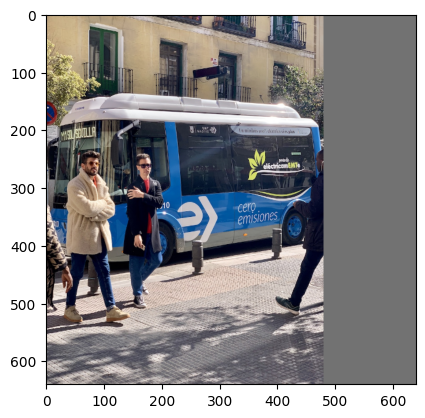

In [10]:
image_reized, ratio = resize_and_pad(image_rgb, imgsz)
print(image_reized.shape, ratio)
print(image_reized.max(), image_reized.min())
plt.imshow(image_reized)

In [11]:
input_array = transform(image_reized)
print(input_array.shape, input_array.max(), input_array.min())

(1, 3, 640, 640) 1.0 0.0


# load model

In [12]:
engine_path = "./weights/rtdetr-l.engine"
trtexec = False # 是否使用自己手动用trtexec导出模式,否则使用yolo导出

In [13]:
# Load TRT engine
trtlogger = trt.Logger(trt.Logger.ERROR)
trtlogger

In [14]:
trt.init_libnvinfer_plugins(trtlogger, namespace="")

True

In [15]:
with open(engine_path, "rb") as f, trt.Runtime(trtlogger) as runtime:
    if not trtexec:
        meta_len = int.from_bytes(f.read(4), byteorder='little')  # read metadata length  yolov8 different from yolov5 in two lines https://github.com/ultralytics/ultralytics/blob/main/ultralytics/nn/autobackend.py#L162
        metadata = json.loads(f.read(meta_len).decode('utf-8'))   # read metadata
    engine = runtime.deserialize_cuda_engine(f.read())  # https://github.com/ultralytics/yolov5/blob/master/models/common.py#L398

In [16]:
context = engine.create_execution_context()
context

## Setup I/O bindings

In [17]:
# Setup I/O bindings
inputs = []        # inputs binding
outputs = []       # outputs binding
allocations = []   # 分配显存空间
for i in range(engine.num_bindings):
    is_input = False

    if trt.__version__ < "8.5":
        if engine.binding_is_input(i):
            is_input = True
        name = engine.get_binding_name(i)
        dtype = engine.get_binding_dtype(i)
        shape = context.get_binding_shape(i)

        # dynamic batch
        if shape[0] < 0 and is_input:
            assert engine.num_optimization_profiles > 0
            profile_shape = engine.get_profile_shape(0, name)
            assert len(profile_shape) == 3  # min,opt,max
            # Set the *max* profile as binding shape
            context.set_binding_shape(i, profile_shape[2])
            shape = context.get_binding_shape(i)
    else:
        name = engine.get_tensor_name(i)
        if engine.get_tensor_mode(name) == trt.TensorIOMode.INPUT:  # type(engine.get_tensor_mode(name)) = <class 'tensorrt.tensorrt.TensorIOMode'>
            is_input = True
        dtype = engine.get_tensor_dtype(name)
        shape = context.get_tensor_shape(name)

        # dynamic batch
        if shape[0] < 0 and is_input:
            assert engine.num_optimization_profiles > 0
            profile_shape = engine.get_tensor_profile_shape(name, 0)
            assert len(profile_shape) == 3  # min,opt,max
            # Set the *max* profile as tensor shape
            context.set_input_shape(name, profile_shape[2])
            shape = context.get_tensor_shape(name)

    if is_input:
        batch_size = shape[0]

    dtype = np.dtype(trt.nptype(dtype)) # DataType.FLOAT => <class 'numpy.float32'> => float32
    size = dtype.itemsize
    for s in shape:
        size *= s

    allocation = cuda.mem_alloc(size)                               # 分配显存
    host_allocation = None if is_input else np.zeros(shape, dtype)  # 分配内存
    binding = {
        "index": i,
        "name": name,
        "dtype": dtype,
        "shape": list(shape),
        "allocation": allocation,
        "host_allocation": host_allocation,
    }
    allocations.append(allocation)
    if is_input:
        inputs.append(binding)
    else:
        outputs.append(binding)

    print("{} '{}' with shape {} and dtype {}".format(
        "Input:" if is_input else "Output:",
        binding['name'], binding['shape'], binding['dtype']))
    # Input 'images' with shape [1, 3, 640, 640] and dtype float32
    # Output 'output0' with shape [1, 25200, 85] and dtype float32

assert batch_size > 0
assert len(inputs) > 0
assert len(outputs) > 0
assert len(allocations) > 0

Input: 'images' with shape [1, 3, 640, 640] and dtype float32
Output: 'output0' with shape [1, 300, 84] and dtype float32


In [18]:
inputs

[{'index': 0,
  'name': 'images',
  'dtype': dtype('float32'),
  'shape': [1, 3, 640, 640],
  'allocation': <pycuda._driver.DeviceAllocation at 0x1c5daeff880>,
  'host_allocation': None}]

In [19]:
outputs

[{'index': 1,
  'name': 'output0',
  'dtype': dtype('float32'),
  'shape': [1, 300, 84],
  'allocation': <pycuda._driver.DeviceAllocation at 0x1c5daf214e0>,
  'host_allocation': array([[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)}]

In [20]:
allocations

# run model

## async infer

In [21]:
# async stream
stream = cuda.Stream()
stream

In [22]:
cuda.memcpy_htod_async(inputs[0]['allocation'], np.ascontiguousarray(input_array), stream)  # 将内存中的图片移动到显存上
context.execute_async_v2(bindings=allocations, stream_handle=stream.handle)                 # infer
for o in range(len(outputs)):                                                               # 将显存中的结果移动到内存上
    cuda.memcpy_dtoh_async(outputs[o]["host_allocation"], outputs[o]["allocation"], stream)
# syncronize threads
stream.synchronize()

In [23]:
results = outputs[0]['host_allocation']

# check result

In [24]:
results.shape

(1, 300, 84)

## 前4个值是loc [:4]

In [25]:
results[0, 0, :4]

array([0.38204017, 0.4445561 , 0.7247159 , 0.46299735], dtype=float32)

## 后面的值是cls [4:]

In [26]:
results[0, 0, 4:]

array([5.95059246e-03, 4.47618822e-03, 1.91132165e-02, 6.18790928e-03,
       8.45231861e-03, 9.47968006e-01, 1.16118994e-02, 9.07359552e-03,
       1.00041637e-02, 6.05287030e-03, 2.60755443e-03, 6.80633215e-03,
       6.29594363e-03, 1.01115657e-02, 5.99633029e-04, 1.29458006e-03,
       4.01948637e-04, 7.98440911e-03, 6.48234878e-03, 1.86182035e-03,
       1.38563225e-02, 9.89371329e-04, 1.54541833e-02, 3.39301140e-03,
       2.40766862e-03, 8.84295721e-03, 3.41999694e-03, 3.92885180e-03,
       4.25638491e-03, 7.26097263e-03, 1.27648888e-02, 4.39908123e-03,
       3.33259627e-03, 4.00279416e-03, 6.95365341e-03, 1.43522127e-02,
       9.02748946e-03, 4.17463481e-03, 4.36720392e-03, 2.71241856e-03,
       7.95318279e-03, 8.35249946e-03, 6.33532135e-03, 4.17069579e-03,
       2.21444084e-03, 4.34734486e-03, 2.92454660e-03, 5.39205223e-03,
       7.58120418e-03, 2.12746020e-03, 8.23296327e-03, 2.45048688e-03,
       7.88548682e-03, 1.34140477e-02, 2.97343172e-03, 3.91621469e-03,
      

In [27]:
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))

# postprocess

In [28]:
print(results.shape)
print(results.min(), results.max())

(1, 300, 84)
0.00016822264 0.951954


In [29]:
bboxes, scores = np.split(results, (4, ), axis=-1)
bboxes.shape, scores.shape

((1, 300, 4), (1, 300, 80))

In [30]:
def threshold(results: np.ndarray, score_threshold: float = 0.25) -> np.ndarray:
    """类似nms操作,不过只需要通过得分限制

    Args:
        results (np.ndarray):           检测到的数据 [b, 8400, 84]
        score_threshold (float):        只有得分大于置信度的预测框会被保留下来,越大越严格

    Returns:
        (list[np.ndarray]): list代表每张图片,里面是一个ndarray,代表一张图片的结果,如果图片没有结果就为 []
            [
                np.ndarray([
                    [class_index, confidence, xmin, ymin, xmax, ymax],
                    ...
                ]),
            ]
    """

    detections = []
    # 循环每张图片的结果
    for result in results: # results: (b, 300, 84)
        bboxes, scores = np.split(result, (4, ), axis=-1)   # (300, 4) (300, 80)
        bboxes = cxcywh2xyxy(bboxes)                        # cxcywh2xyxy

        confidences: np.ndarray = scores.max(axis=-1)       # (300,)
        class_indexes: np.ndarray = scores.argmax(axis=-1)  # (300,)

        keep = confidences >= score_threshold               # (300,)

        bboxes_k = bboxes[keep]                             # (9, 4)
        confidences_k = confidences[keep]                   # (9,)
        class_indexes_k = class_indexes[keep]               # (9,)

        detection = np.concatenate(                        # (9, 6)
            (np.expand_dims(class_indexes_k, axis=-1),
            np.expand_dims(confidences_k, axis=-1),
            bboxes_k),
            axis=-1
        )
        detections.append(detection)

    return detections

In [31]:
thre_results = threshold(results)
print(thre_results[0].shape)
thre_results[0].min(), thre_results[0].max()

(9, 6)


(-0.00023841112852096558, 27.0)

In [32]:
origin_shape = image_rgb.shape
origin_shape

(1080, 810, 3)

# 坐标还原到原图尺寸

In [36]:
detections = to_origin_size(thre_results[0], ratio, origin_shape)
print(detections.min(), detections.max())

0.0 904.66721534729


# 画图

In [37]:
image_draw = figure(detections, cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR))

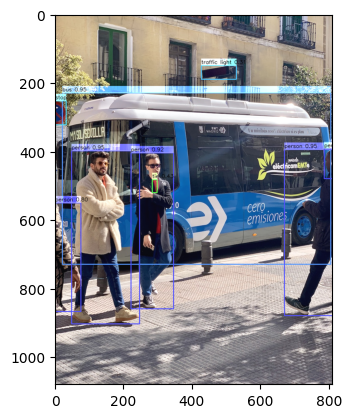

In [38]:
plt.imshow(cv2.cvtColor(image_draw, cv2.COLOR_BGR2RGB))